In [1]:
from functools import reduce
import numpy as np
from constants import *
from green_function import *
#import holoviews
from scipy import linalg as sla
import matplotlib as mp
plt.style.use('seaborn')		# Setting the plotting style
mp.rcParams['figure.figsize'] = (15, 10)  # Setting the size of the plots
import numpy.linalg as la 


N = 100

def evolution_operator(hamiltonians, T):
    n = len(hamiltonians)
    exps = [sla.expm(-1j * h * T / n) for h in hamiltonians]
    return reduce(np.matmul, exps)


def calculate_finite_spectrum(periods, hamiltonians):
    energies = []
    for T in periods:
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1) ** n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real


def calculate_bands(momenta, hamiltonians_k, T):
    energies = []
    for k in momenta:
        hamiltonians = [h_k(k) for h_k in hamiltonians_k]
        U = evolution_operator(hamiltonians, T)
        phases = np.angle(la.eigvals(U))
        phases = np.sort(np.abs(phases))
        ev = np.sort([(-1) ** n * val for n, val in enumerate(phases)])
        energies.append(ev)
    return np.array(energies).real

In [2]:
def onsite(mu=mu):
    return -mu * s_z


def hopping(t=t, delta=delta):
    return -t * s_z +  1j * delta * s_y

In [3]:
periods = np.linspace(0.02 * t, 5 * t, 100)
momenta = np.linspace(-2*np.pi, 2*np.pi,100)

h_1 = Hamiltonian(d,N,onsite(mu=3*t),hopping())
h_2 = Hamiltonian(d,N,onsite(mu=4*t),hopping())


energies = calculate_finite_spectrum(periods, [h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()])
spectrum = np.array([calculate_bands(momenta, [h_1.k_space_hamiltonian, h_2.k_space_hamiltonian], T) for T in periods])

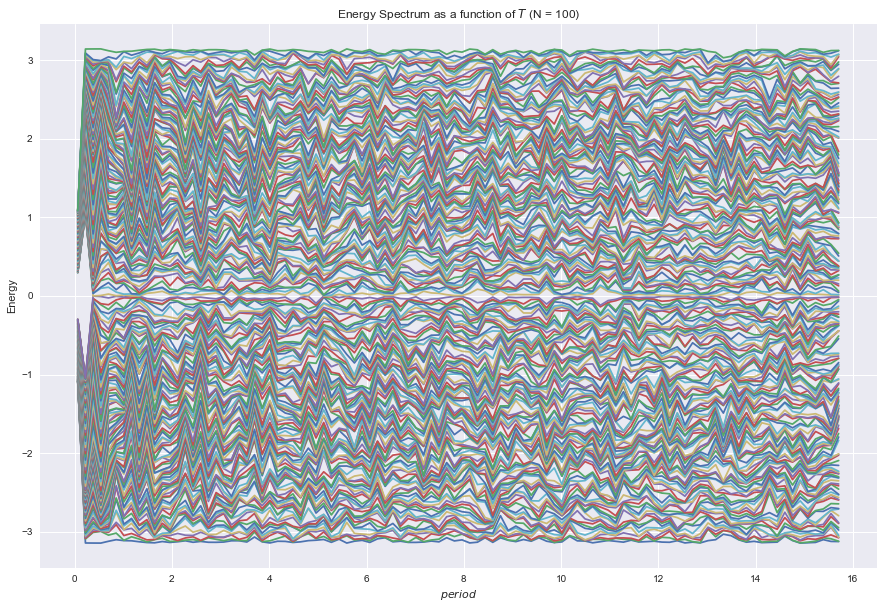

In [4]:
plt.title("Energy Spectrum as a function of $T$ (N = {})".format(N))
for i in range(d*N):
    plt.plot(periods,energies[:,i])
plt.ylabel('Energy')
plt.xlabel('$period$')
plt.show()

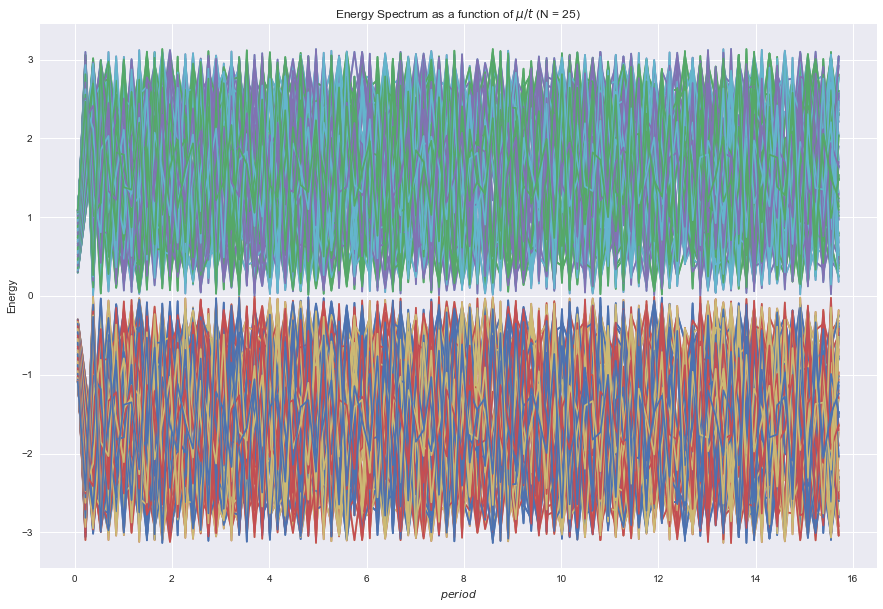

In [5]:
plt.title("Energy Spectrum as a function of $\mu/t$ (N = 25)")
for i in range(100):
    plt.plot(periods,spectrum[:,i])
plt.ylabel('Energy')
plt.xlabel('$period$')
plt.show()
#plt.savefig('interesting bulk spectrum.png')

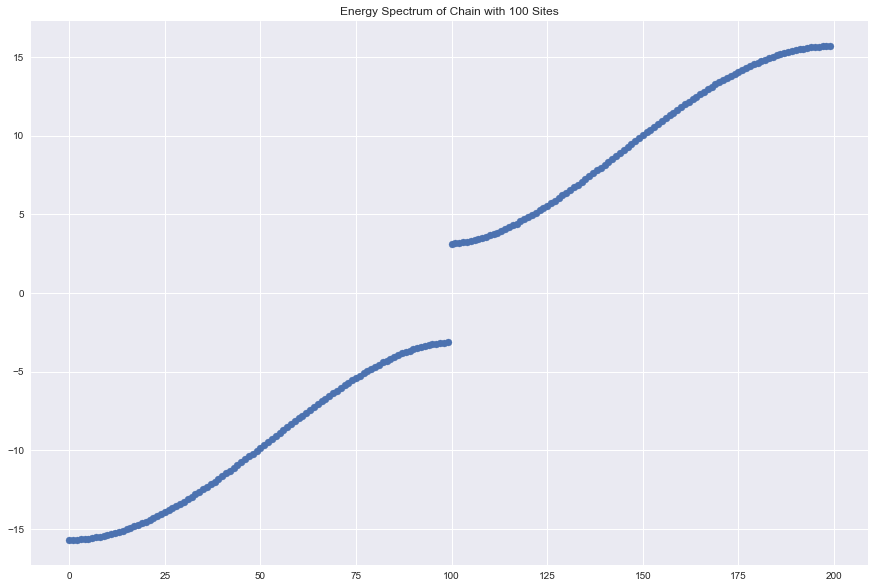

In [6]:
def plot_spectrum(Hmat):
    evals,evecs = la.eigh(Hmat)
    evals = evals.real
    plt.scatter(np.arange(len(evals)),evals)
    plt.title('Energy Spectrum of Chain with {} Sites'.format(N))
    plt.show()
    
plot_spectrum(h_1.lattice_hamiltonian())

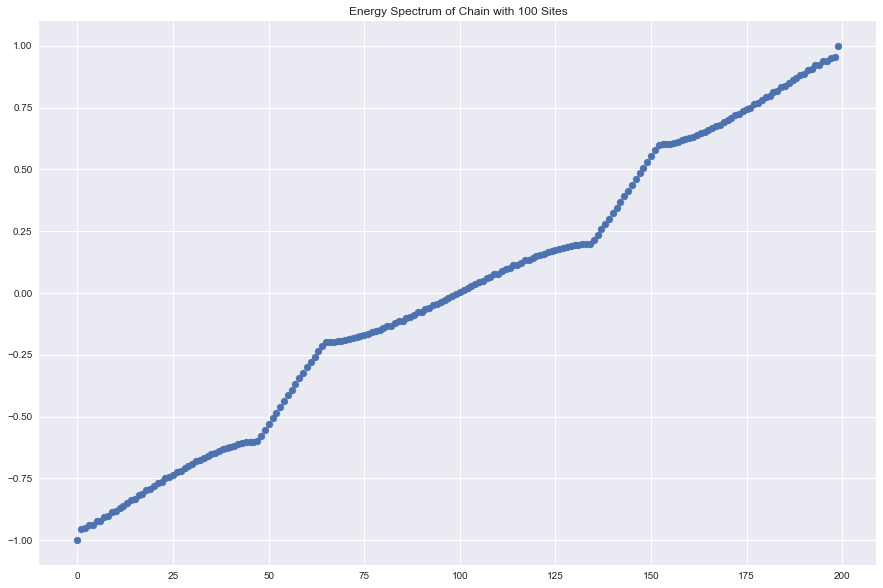

In [7]:
U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=0.4)
h_f = 1j * sla.logm(U)/np.pi
plot_spectrum(h_f)

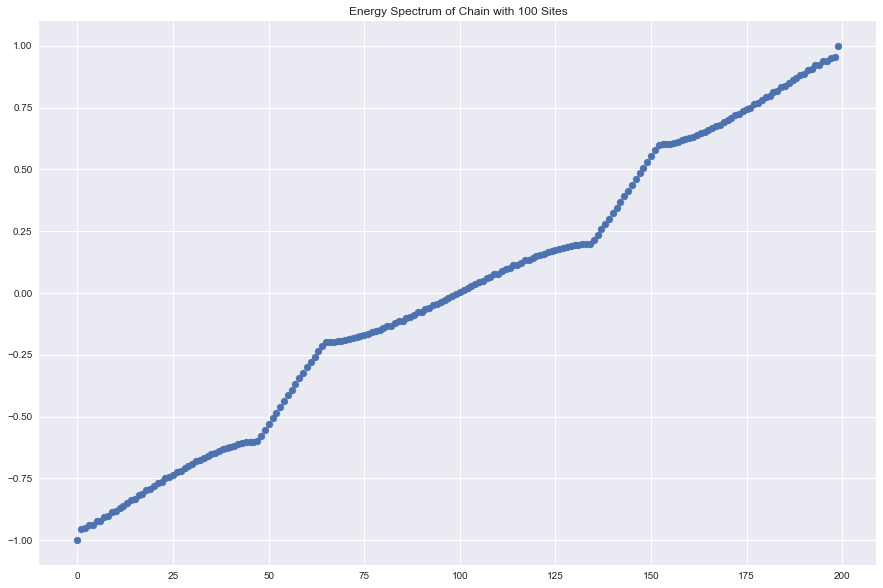

In [8]:
plot_spectrum(h_f)

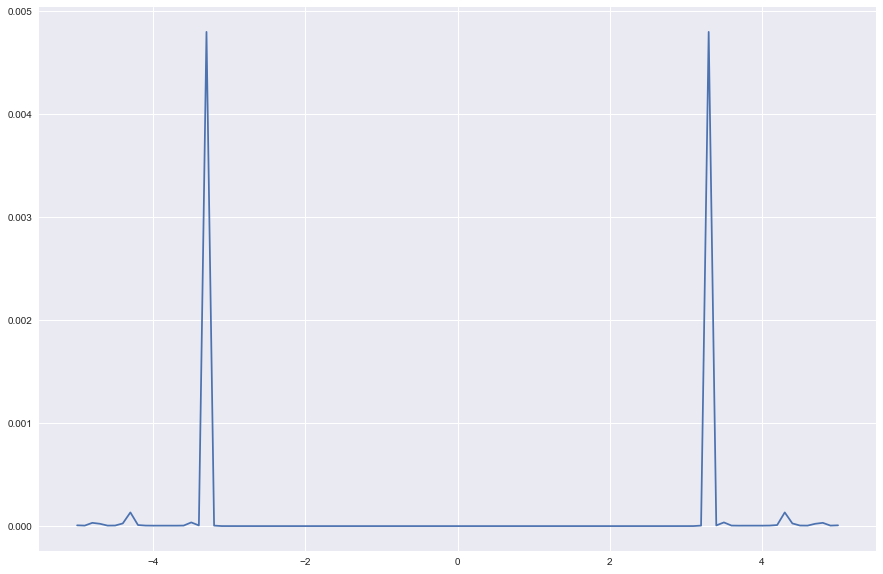

In [9]:
'''G = [np.trace(la.inv(w-0.000001j-h_f))[0:d,0:d].imag for w in range(100)]
plt.plot(G)
'''
ldos = []
var_E = np.linspace(-5,5,101)
for E in var_E:
    G = la.inv((E-0.000001j)*np.eye(h_1.d*h_1.N)-h_1.lattice_hamiltonian())
    G_L_img = G[0:d,0:d].imag
    ldos.append(np.trace(G_L_img))
plt.plot(var_E,ldos)

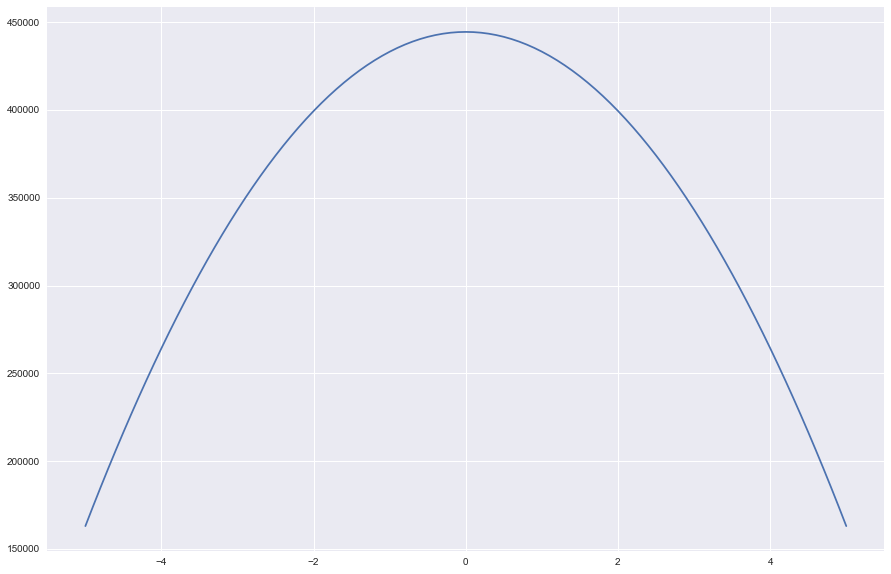

In [10]:
ldos = []
var_mu = np.linspace(-5,5,101)
for m in var_mu:
    h = Hamiltonian(d,N,onsite(mu=m),hopping())
    G = la.inv((-0.000001j)*np.eye(h.d*h.N)-h.lattice_hamiltonian())
    G_L_img = G[0:d,0:d].imag
    ldos.append(G_L_img[0,0])
plt.plot(var_E,ldos)

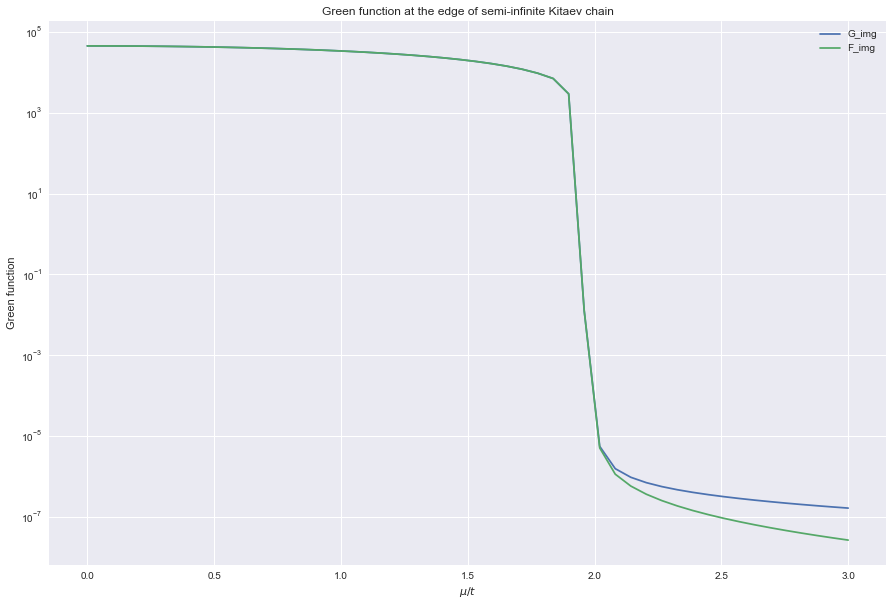

In [11]:
var_mu = np.linspace(0*t,3*t,50)
F_img = np.zeros([len(var_mu)])
G_img = np.zeros([len(var_mu)])
for i in range(len(var_mu)):
    hamiltonian = Hamiltonian(d,N,onsite(mu=var_mu[i]),hopping())
    G_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(d*N)-hamiltonian.lattice_hamiltonian())[0,0].imag])
    F_img[i] = 1*np.array([la.inv(1j*0.00001*np.eye(d*N)-hamiltonian.lattice_hamiltonian())[0,1].imag])
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_mu/t,G_img, label='G_img')
plt.plot(var_mu/t,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$\mu/t$')
plt.yscale('log')
plt.legend()
plt.show()

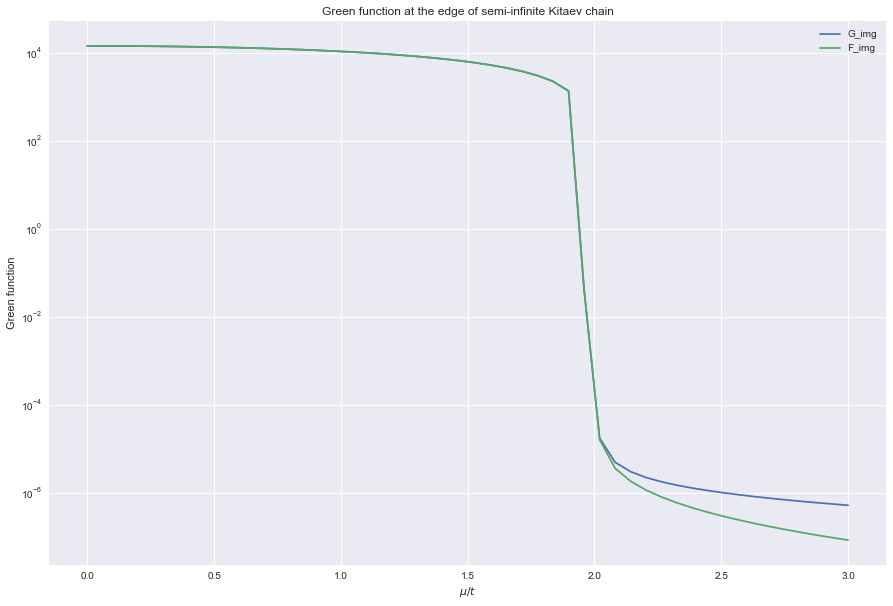

In [12]:
def recursive_green_function(z,G,mu_a):
    y = z
    u = -mu_a * s_z
    V = -t * s_z + 1j * delta * s_y
    V_dagger = -t * s_z - 1j * delta * s_y
    G = la.inv(z*s_0 - u - np.matmul(V_dagger,np.matmul(G,V)))
    K=G
    yield G
    yield from recursive_green_function(z=y,G=K,mu_a=mu_a)


var_mu = np.linspace(0*t,3*t,50)
F_img = np.zeros([len(var_mu)])
G_img = np.zeros([len(var_mu)])
G=[]
G_0=[]
for i in range(len(var_mu)):
    G_0.append(la.inv(0.00001j * t * s_0 - var_mu[i] * s_z))
    G.append(recursive_green_function(z=0.00001j*t,mu_a=var_mu[i],G=G_0[i]))
    for n in range(N-1):
        next(G[i])
    G_img[i] = -1*np.array([next(G[i])[0,0].imag])
    F_img[i] = -1*np.array([next(G[i])[0,1].imag])
    #the above line takes value from the N+1 site. you should modify the code later!!!
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_mu/t,G_img, label='G_img')
plt.plot(var_mu/t,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$\mu/t$')
plt.yscale('log')
plt.legend()
plt.show()

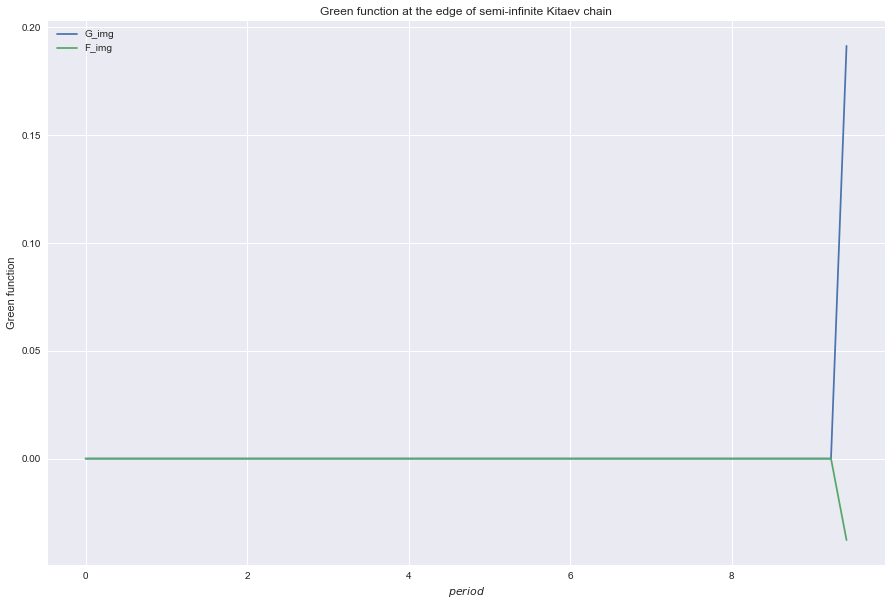

In [13]:
var_time = np.linspace(0*t,3*t,50)
F_img = np.zeros([len(var_time)])
G_img = np.zeros([len(var_time)])
for time in var_time:
    U = evolution_operator([h_1.lattice_hamiltonian(), h_2.lattice_hamiltonian()],T=time)
    h_f = 1j * sla.logm(U)/np.pi
    hamiltonian = Hamiltonian(d,N,onsite(mu=var_mu[i]),hopping())
    G_img[i] = -1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,0].imag])
    F_img[i] = 1*np.array([la.inv(1j*0.00001*np.eye(len(h_f))-h_f)[0,1].imag])
plt.title("Green function at the edge of semi-infinite Kitaev chain")
plt.plot(var_time,G_img, label='G_img')
plt.plot(var_time,F_img,label='F_img')
#plt.plot(var_mu/t,G_img-F_img,label = 'G_img-F_img')
plt.ylabel('Green function')
plt.xlabel('$period$')
#plt.yscale('log')
plt.legend()
plt.show()